# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### Data analysis
#### MVA Selection: One vs All (OvO) training

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import os
from particle import Particle
import mplhep
from matplotlib import pyplot as plt
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyML')
import RooPyFit as rpf
import RooPyShort as rsh
import RooPyML as rml

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()
mplhep.styles.use(mplhep.styles.LHCb2)

%jsroot on

Welcome to JupyROOT 6.28/04
2024-05-11 06:51:12.770163
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./root_files"):
    os.makedirs("./root_files")
else:
    print("root_files directory already exists")

Graphs directory already exists
root_files directory already exists


## RDataFrame definition

### Data

In [3]:
Data_MagD18_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2018'
nfiles = len(os.listdir(Data_MagD18_path))

data_for_train = set(["{0}/DsJ_Data_MagD18_{1}.root".format(Data_MagD18_path, i) for i in range(100, 120)])
  
Data_files = "DsJ_*.root"
dtt = "DsGammaTuple"

tdf_data = ROOT.RDataFrame("{0}/DecayTree".format(dtt), "{0}/{1}".format(Data_MagD18_path, Data_files))
tdf_data = tdf_data.Define("DsgM", "Dsg_M-Ds_M+1969")
  
tdf_data_train = ROOT.RDataFrame("{0}/DecayTree".format(dtt), data_for_train)
tdf_data_train = tdf_data_train.Define("DsgM", "Dsg_M-Ds_M+1969")

### MonteCarlo

In [4]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds1_sig_files = "Ds1DsGamma*.root"
MC_Dsst_sig_files = "DsstDsGamma*.root"
dtt = "DsGammaTuple"

tdf_Dsst = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"DsstDsGamma*.root")
tdf_Dsst = tdf_Dsst.Define("DsgM", "Dsg_M-Ds_M+1969")

tdf_Ds1 = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"Ds1DsGamma*.root")
tdf_Ds1 = tdf_Ds1.Define("DsgM", "Dsg_M-Ds_M+1969")

## TRUEIDs and MCMatching

In [5]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_sig = tdf_Dsst.Filter(TRUEID_Dsst)
tdf_Ds1_sig = tdf_Ds1.Filter(TRUEID_Ds1)

### Pre-Selection

In [6]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

off_sel  = "gamma_PT > 800 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20"
nPVs_req = "nPVs == 1"

L0_cond    = "(Ds_L0HadronDecision_TOS == 1 | Dsg_L0Global_TIS == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

Sel = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds)

Dsst_window = "DsgM > 2050 && DsgM < 2250"
Ds1_window  = "DsgM > 2350 && DsgM < 2600"

In [7]:
tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter("{0} && {1}".format(Sel, Dsst_window))
tdf_Ds1_sig_sel = tdf_Ds1_sig.Filter("{0} && {1}".format(Sel, Ds1_window))

tdf_data_sel = tdf_data.Filter(Sel)
tdf_data_train_sel = tdf_data_train.Filter(Sel)

### Signal RDF 

In [8]:
tdf_sig_1 = tdf_Dsst_sig_sel
tdf_sig_2 = tdf_Ds1_sig_sel

print(f"Signal Dsst candidates: {tdf_sig_1.Count().GetValue()}")
print(f"Signal Ds1  candidates: {tdf_sig_2.Count().GetValue()}")

Signal Dsst candidates: 14733
Signal Ds1  candidates: 70128


### Background dataset $\to$ $M(D_s^+\gamma) > 2600 \text{ } \mathrm{MeV/c^2}$

In [9]:
no_sig_region = "DsgM > 2600"

tdf_bkg = tdf_data_train_sel.Filter(no_sig_region)

print(f"Background candidates: {tdf_bkg.Count().GetValue()}")

Background candidates: 89502


## Train set preparation

### Training features

In [10]:
base_features = ["gamma_CL", "gamma_ShowerShape", "gamma_PE", "gamma_PT",
                 "Ds_ENDVERTEX_CHI2", "Ds_FDCHI2_OWNPV", "Ds_IP_OWNPV", "Ds_0.50_nc_mult"]

base_features = ["gamma_CL", "gamma_ShowerShape", "gamma_PE", "gamma_PT", "Ds_0.50_nc_mult"]

features = base_features + ["DsgM", "nVeloTracks"]

### Train dataset

In [11]:
# Signal 1 pandas dataframe
df_sig_1 = rsh.rdf_to_pdf(tdf_sig_1, base_features)
df_sig_1 = df_sig_1.copy()
df_sig_1["type"] = 1

In [12]:
# Signal 2 pandas dataframe
df_sig_2 = rsh.rdf_to_pdf(tdf_sig_2, base_features)
df_sig_2 = df_sig_2.copy()
df_sig_2["type"] = 2

In [13]:
# Background pandas dataframe
df_bkg = rsh.rdf_to_pdf(tdf_bkg, base_features)
df_bkg = df_bkg.copy()
df_bkg["type"] = 0

In [14]:
# Data pandas dataframe
df_data = rsh.rdf_to_pdf(tdf_data_sel, features)

print(len(df_data["gamma_CL"]))

9100463


## BDT clasifiers

### Training

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

nclasses = 3

#bdt = OneVsRestClassifier(gbc)

from itertools import combinations

# Number of classes

# Generate all possible class pairs
class_pairs = list(combinations(range(nclasses), 2))

# Create a dictionary to map estimator indices to class pairs
estimator_class_pairs = {i: class_pairs[i] for i in range(nclasses)}

print("Estimator index : Class pair")
for index, pair in estimator_class_pairs.items():
    print(f"{index} : {pair}")

Estimator index : Class pair
0 : (0, 1)
1 : (0, 2)
2 : (1, 2)


In [41]:
df_per_class = {"0": df_bkg, 
                "1": df_sig_1,
                "2": df_sig_2}

gbc_models = {}
rfc_models = {}
df_train_sets = {}

for pair in class_pairs:
    class_a = str(pair[0])
    class_b = str(pair[1])
    
    df_train = pd.concat([df_per_class[class_a], df_per_class[class_b]], copy=True, ignore_index=True)
    df_train_shuf = shuffle(df_train)
    
    df_train_sets[pair] = df_train_shuf 
    
    gbc_models[pair] = GradientBoostingClassifier()
    rfc_models[pair] = RandomForestClassifier()
    
df_train = pd.concat([df_bkg, df_sig_1, df_sig_2], copy=True, ignore_index=True)

df_train_shuf = shuffle(df_train)
    

In [1]:
print(gbc_models)

NameError: name 'gbc_models' is not defined

In [17]:
from sklearn.preprocessing import LabelBinarizer

for pair in class_pairs:
    df_x = (df_train_sets[pair])[base_features]
    df_y = (df_train_sets[pair])["type"]
    
    gbc_models[pair].fit(df_x, df_y)
    rfc_models[pair].fit(df_x, df_y)

In [18]:

for df in [df_bkg, df_sig_1, df_sig_2, df_data, df_train_shuf]:
    for pair in class_pairs:
        class_a = str(pair[0]); class_b = str(pair[1])
        
        df[f'GBC_Prob_{class_a}_to_{class_b}'] = gbc_models[pair].predict_proba(df[base_features])[:,0]
        df[f'RFC_Prob_{class_a}_to_{class_b}'] = rfc_models[pair].predict_proba(df[base_features])[:,0]

Text(0.5, 0.98, 'GradientBoostClassifier over train set')

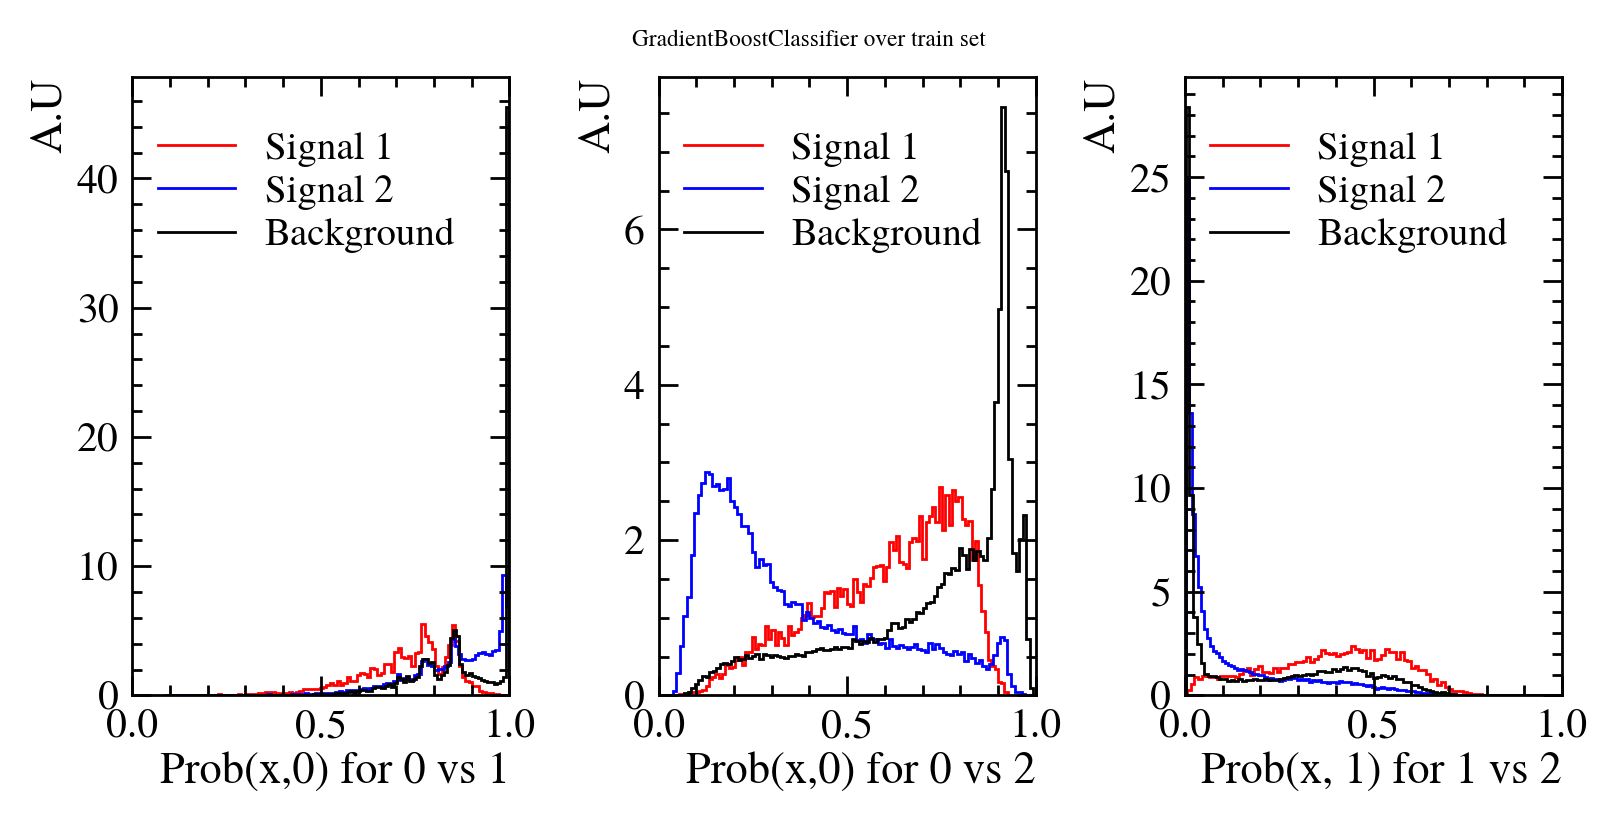

In [19]:
plt.figure(1, figsize=(16, 8))
plt.subplot(1, 3, 1)
rml.plot("GBC_Prob_0_to_1", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("GBC_Prob_0_to_1", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("GBC_Prob_0_to_1", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"Prob(x,0) for 0 vs 1")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 2)
rml.plot("GBC_Prob_0_to_2", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("GBC_Prob_0_to_2", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("GBC_Prob_0_to_2", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"Prob(x,0) for 0 vs 2")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 3)
rml.plot("GBC_Prob_1_to_2", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("GBC_Prob_1_to_2", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("GBC_Prob_1_to_2", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"Prob(x, 1) for 1 vs 2")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.suptitle("GradientBoostClassifier over train set")

In [20]:
plt.figure(1, figsize=(16,8))
plt.subplot(1, 3, 1)
rml.plot("RFC_Prob_0_to_1", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("RFC_Prob_0_to_1", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("RFC_Prob_0_to_1", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"Prob(x,0) for 0 vs 1")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 2)
rml.plot("RFC_Prob_0_to_2", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("RFC_Prob_0_to_2", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("RFC_Prob_0_to_2", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"Prob(x,0) for 0 vs 2")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 3)
rml.plot("RFC_Prob_1_to_2", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("RFC_Prob_1_to_2", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("RFC_Prob_1_to_2", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"Prob(x, 1) for 1 vs 2")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.suptitle("RandomForestClassifier over train set")

Text(0.5, 0.98, 'RandomForestClassifier over train set')

#### $M(D_s^+\gamma)$ BDT cut try

In [21]:
df_data_2 = df_data.query("DsgM < 2800")
df_data_GBC_cut = df_data_2.query("GBC_Prob_0_to_2 < 0.5")
df_data_RFC_cut = df_data_2.query("RFC_Prob_0_to_2 < 0.5")

plt.figure(1)
rml.plot("DsgM", df_data_2, label="No BDT cut", color="k", density=True)
rml.plot("DsgM", df_data_GBC_cut, label="GBC_Prob_0_to_2 < 0.5", color="b", density=True)
rml.plot("DsgM", df_data_RFC_cut, label="RFC_Prob_0_to_2 < 0.5", color="r", density=True)
plt.xlabel(r"$M(D_s^+\gamma)$ $\mathrm{[MeV/c^2]} $")
plt.ylabel(r'A.U')
plt.title(r'MagDown 2018 data')
plt.legend()

### Feature Importance

Text(0.5, 1.0, 'Feature importance')

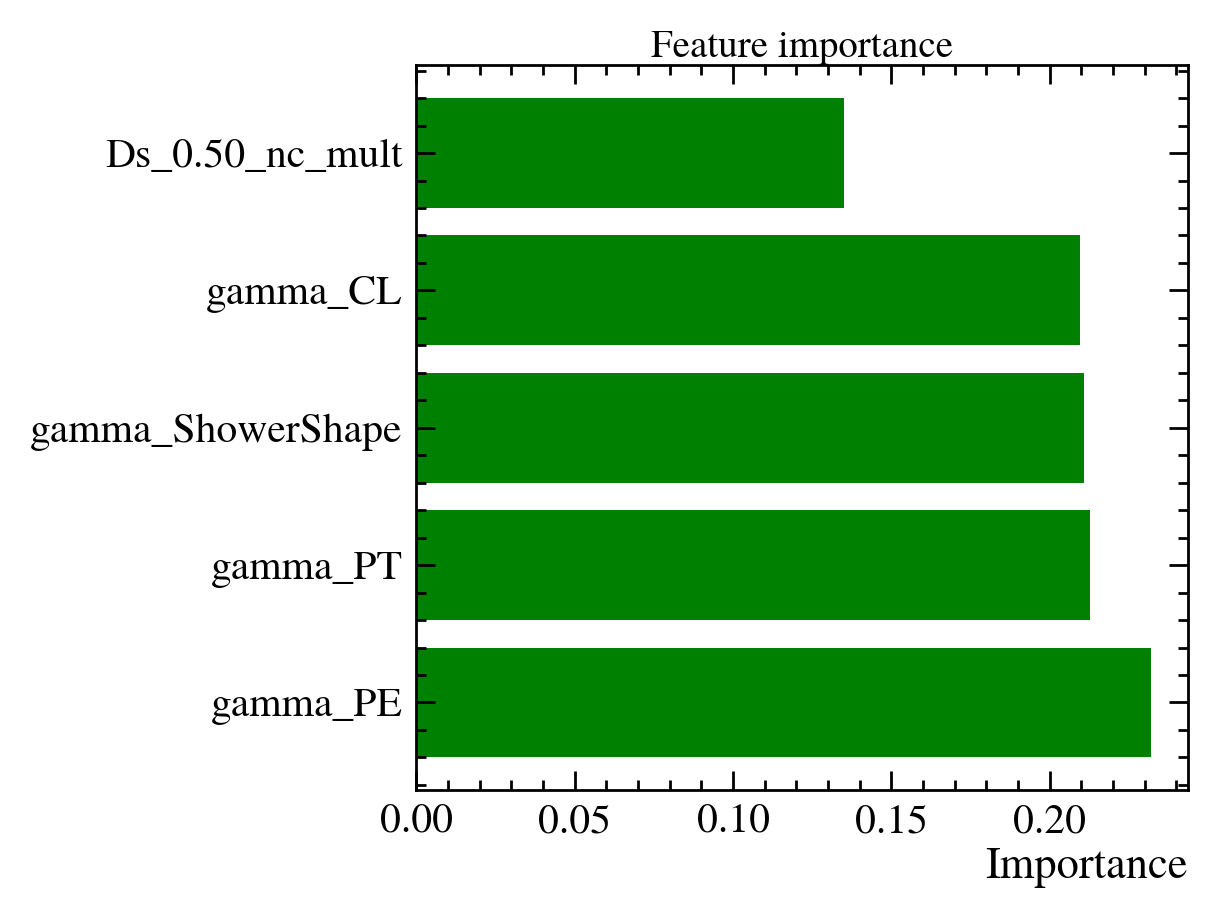

In [22]:
plt.figure(1)
rml.feature_importance_plot(gbc_models[(0, 1)], base_features, color="blue")
plt.title(r"Feature importance")
#if base:
#    plt.savefig("Train_plots/Comp_Dspi0L_GBC_feature_importance_base.pdf", dpi=300, bbox_inches='tight')
#else:
#    plt.savefig("Train_plots/Comp_Dspi0L_GBC_feature_importance_all.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
rml.feature_importance_plot(rfc_models[(0, 1)], base_features, color="green")
plt.title(r"Feature importance")
#if base:
#    plt.savefig("Train_plots/Comp_Dspi0L_ADA_feature_importance_base.pdf", dpi=300, bbox_inches='tight')
#else:
#    plt.savefig("Train_plots/Comp_Dspi0L_ADA_feature_importance_all.pdf", dpi=300, bbox_inches='tight')

### Training performance


#### Confusion matrix

In [23]:
df_train_shuf["GBC type pred"] = gbc_models[estimator_class_pairs[0]].predict(df_train_shuf[base_features])
df_train_shuf["RFC type pred"] = rfc_models[estimator_class_pairs[0]].predict(df_train_shuf[base_features])

conf_gbc = confusion_matrix(df_train_shuf["type"], df_train_shuf["GBC type pred"])
conf_rfc = confusion_matrix(df_train_shuf["type"], df_train_shuf["RFC type pred"])

print("Confusion matrix for gbc algorithm")
print(conf_gbc)

print("Confusion matrix for rfc algorithm")
print(conf_rfc)

Confusion matrix for gbc algorithm
[[89010   492     0]
 [13857   876     0]
 [69071  1057     0]]
Confusion matrix for rfc algorithm
[[89502     0     0]
 [    3 14730     0]
 [68096  2032     0]]


In [24]:
pairs = list(combinations(np.unique(df_train_shuf["type"]), 2))

pairs

[(0, 1), (0, 2), (1, 2)]

#### ROC curve

In [36]:
from sklearn.preprocessing import LabelBinarizer

# Para el ovo, alg tiene que ser un diccionario como los que hai en las celdas de arriba
def roc_curve_plot(alg, data, training_features, category, 
                   color=None, multi_class="ova"):
    
    if type(alg) is not dict:
    # Binary
        if alg.n_classes_ == 2:
            y_score = alg.predict_proba(data[training_features])[:, 1]
            fpr, tpr, _ = roc_curve(data[category], y_score)
            area = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'(AUC = {area:.2f})', color=color)

    # Multiclass    
        else:
        # OneVsAll Classifiers
            if multi_class == "ova":
                label_binarizer = LabelBinarizer().fit(data[category])
                y_binary = label_binarizer.transform(data[category])

                y_score = alg.predict_proba(data[training_features])

                fprs = [(roc_curve(y_binary[:, i], y_score[:, i]))[0] for i in range(alg.n_classes_)]  
                tprs = [(roc_curve(y_binary[:, i], y_score[:, i]))[1] for i in range(alg.n_classes_)] 
                areas = [auc(fprs[i], tprs[i]) for i in range(alg.n_classes_)]           

                for i in range(alg.n_classes_):
                    plt.plot(fprs[i], tprs[i], label=f'{i} class (AUC = {areas[i]:.2f})', linestyle="-.")

                # Micro Average
                fpr_micro, tpr_micro, _ = roc_curve(y_binary.ravel(), y_score.ravel())
                area_micro = auc(fpr_micro, tpr_micro)

                plt.plot(fpr_micro, tpr_micro, label=f'Micro-Av (AUC = {area_micro:.2f})', color="blue")

                # Macro Average
                fpr_grid = np.linspace(0, 1, 1000)
                mean_tpr = np.zeros_like(fpr_grid)       
                for i in range(alg.n_classes_):
                    mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

                mean_tpr /= alg.n_classes_
                fpr_macro = fpr_grid; tpr_macro = mean_tpr
                area_macro = auc(fpr_macro, tpr_macro)

                plt.plot(fpr_macro, tpr_macro, label=f'Macro-Av (AUC = {area_macro:.2f})', color="red")
    else:
        # OneVsOne Classifiers
        if multi_class == "ovo":
            pairs = list(combinations(np.unique(data[category]), 2))

            data_per_pair = {pair: data.query(f"type == {pair[0]} | type == {pair[1]}") for pair in pairs}
            
            binarizers = {pair: LabelBinarizer().fit((data_per_pair[pair])[category]) for pair in pairs}
            
            y_binaries = {pair: binarizers[pair].transform((data_per_pair[pair])[category]) for pair in pairs}
            y_scores   = {pair: alg[pair].predict_proba((data_per_pair[pair])[training_features]) for pair in pairs}
            
            y_binaries = {pair: (y_binaries[pair]) for pair in pairs}
            y_scores   = {pair: (y_scores[pair])[:, 1] for pair in pairs}
            
            fprs = [(roc_curve(y_binaries[pair], y_scores[pair]))[0] for pair in pairs]
            tprs = [(roc_curve(y_binaries[pair], y_scores[pair]))[1] for pair in pairs]
            areas = [auc(fprs[i], tprs[i]) for i in range(len(pairs))]    
            
            for i in range(len(pairs)):
                plt.plot(fprs[i], tprs[i], 
                         label=f'{(pairs[i])[0]} vs {(pairs[i])[1]} (AUC = {areas[i]:.2f})', 
                         linestyle="-.")       

            fpr_grid = np.linspace(0, 1, 1000)
            mean_tpr = np.zeros_like(fpr_grid)       
            
            for i in range(len(pairs)):
                mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

            mean_tpr /= len(pairs)
            fpr_macro = fpr_grid; tpr_macro = mean_tpr

            area_macro = auc(fpr_macro, tpr_macro)
                
            plt.plot(fpr_macro, tpr_macro, label=f'Macro-Av (AUC = {area_macro:.2f})', color="red")
    
    # Default plot settings        
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.gca().set_aspect('equal', adjustable='box')

{(0, 1): array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), (0, 2): array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]]), (1, 2): array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])}
{(0, 1): array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]]), (0, 2): array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]]), (1, 2): array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])}


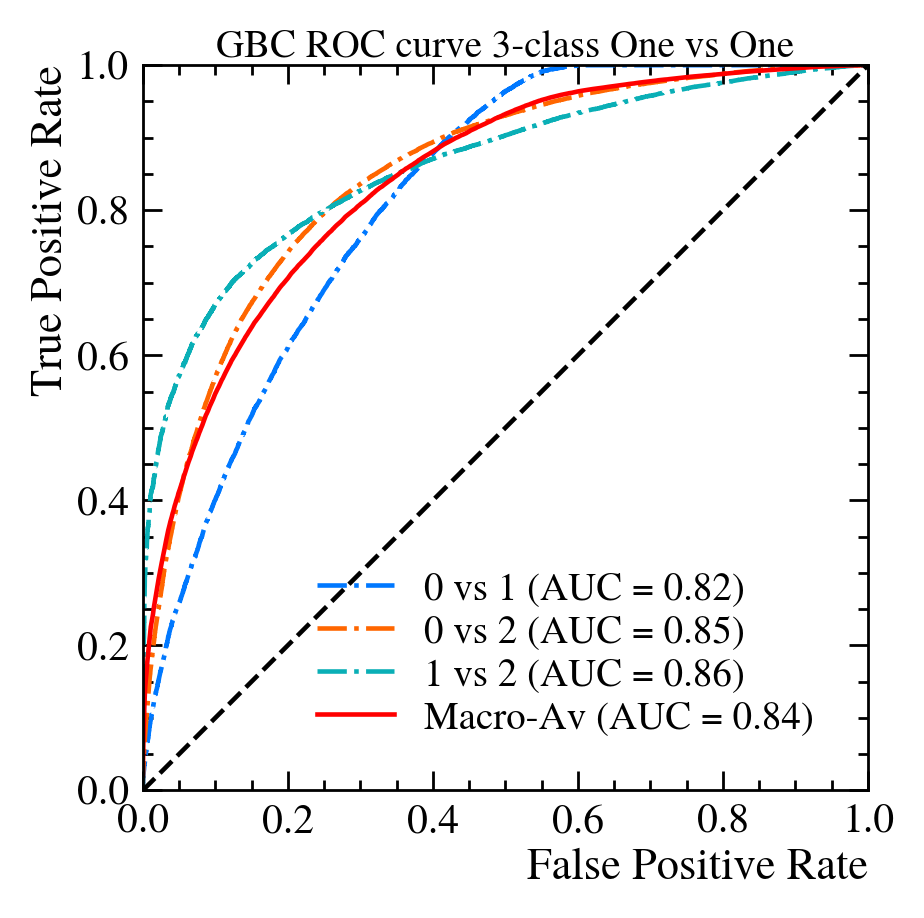

In [40]:
plt.figure(1)
roc_curve_plot(gbc_models, df_train_shuf, base_features, "type",
               color="blue", label="GBC", multi_class="ovo")
plt.legend()
plt.title("GBC ROC curve 3-class One vs One")
plt.savefig("Graphs/Comp_DsgL_BDT_roc_curve_base_OvO.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
roc_curve_plot(rfc_models, df_train_shuf, base_features, "type",
               color="blue", label="RFC", multi_class="ovo")
plt.legend()
plt.title("RFC ROC curve 3-class One vs One")
plt.savefig("Graphs/Comp_DsgL_RF_roc_curve_base_OvO.pdf", dpi=300, bbox_inches='tight')